### Imports

In [ ]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline
import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
from google.colab import files
 
# select the dataframe of interest
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
df_test = pd.read_csv("test.csv").sort_values(by=["Id"])
df_train = pd.read_csv("train.csv")
df_sample = pd.read_csv("sample_submission.csv").sort_values(by=["Id"])

### Funciones auxiliares

In [ ]:
# missing values
def calculate_missing_values(df):
  col_w_missing_value = [col for col in df.columns if df[col].isnull().any()]
  missing_values_tot = df[col_w_missing_value].isnull().sum().sort_values(ascending=False)

  # get the percentage of null values per column
  missing_values_perc = (missing_values_tot/df[col_w_missing_value].isnull().count()).sort_values(ascending=False)

  # create the missing data table to better visualize
  missing_data = pd.concat([missing_values_tot, missing_values_perc], axis=1, keys=["Total", "Percent"])
  return (missing_data)

# Ordinal Encoding
def ordinal_encoder(df, features):
  X = df.copy()
  ordinal_encoder = OrdinalEncoder()
  
  X[features] = ordinal_encoder.fit_transform(df[features])
  return (X)

# mutual information
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# plot score of MI
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

### EDA

(Exploratory data analysis)

Veamos los tipos de variables que tenemos


In [ ]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

In [ ]:
quantitative

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [ ]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

Teniendo en cuenta nuestro target (SalePrice) podemos observar que hay algunas variables **cuantitativas** que presentan un nivel de correlacion alto con nuestro target.
Por ejm: OverallQual, YearBuilt, YearRemodAdd, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea.

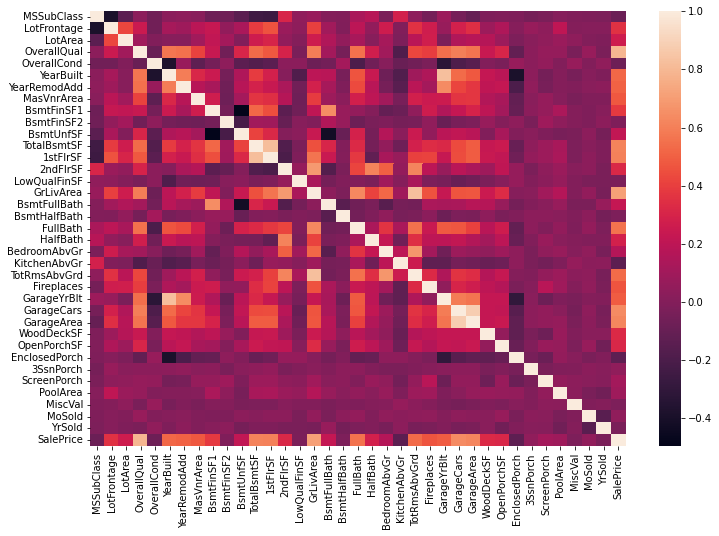

In [ ]:
plt.figure(1,figsize=(12,8))
corr_quan= df_train[quantitative + ["SalePrice"]].corr()
sns.heatmap(corr_quan)

Podemos hacer el mismo analisis con respecto a las variables **cualitativas**,
vemos que aquellas variables que presentan un nivel de correlacion alto son las siguientes: Alley, Foundation.
Notar que existen algunas variables que podrian tener una relevancia significativa con respecto a nuestro target pero que en la matriz de correlaciones no presentan valores altos de correlacion con nuestro target, por ejm la variable **Neighborhood**.

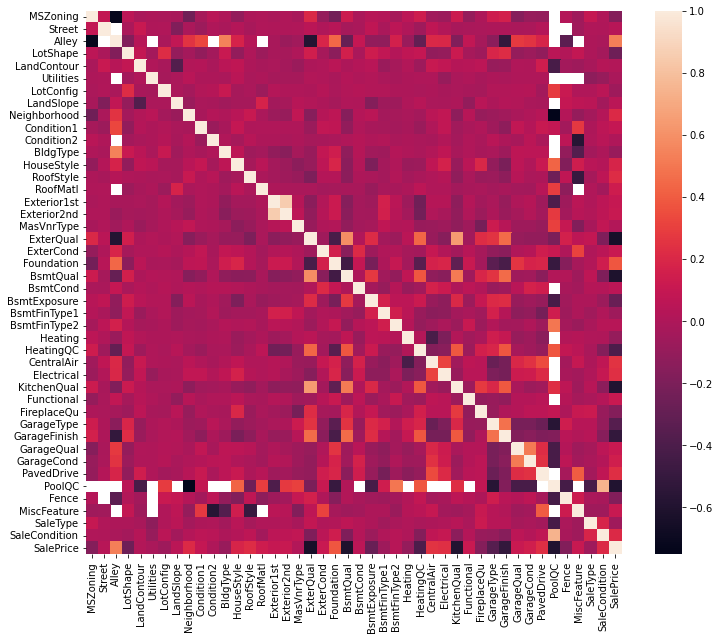

In [ ]:
# tratamos variables categoricas
qualitative_encode = ordinal_encoder(df_train, qualitative)

plt.figure(2,figsize=(12,10))
corr_qual= qualitative_encode[qualitative + ["SalePrice"]].corr()
sns.heatmap(corr_qual)

Vamos a guardar el nombre de estas variables que presentan un grado alto de correlacion para tenerlas en cuenta cuando hagamos nuestra lista de features candidatos.

In [ ]:
high_corr_qual = corr_qual[corr_qual["SalePrice"] > 0.3].index.drop("SalePrice").tolist()
high_corr_quan = corr_quan[corr_quan["SalePrice"] > 0.5].index.drop("SalePrice").tolist()

high_corr_lvl = np.append(high_corr_qual, high_corr_quan)

Una vez analizada la matriz de correlaciones, antes de hacer feature engineering y data cleaning, vamos a analizar la metrica de **mutual information** para tener en cuenta posibles candidatos a features que con la matriz de correlaciones podriamos no llegar a apreciar.

Para ello debemos tratar las variables categoricas pirmero.

In [ ]:
df_train2 = df_train.copy()
df_train2.update(df_train2[quantitative].fillna(0))
df_train2.update(df_train2[qualitative].fillna("None"))
target = df_train2.SalePrice

In [ ]:
mi_scores = make_mi_scores(df_train2[qualitative + quantitative], target)
mi_scores

OverallQual     5.786503e-01
Neighborhood    5.253900e-01
GarageArea      4.927946e-01
GrLivArea       4.328080e-01
YearBuilt       4.087151e-01
                    ...     
Utilities       1.887379e-15
PoolArea        2.220446e-16
PoolQC          0.000000e+00
MiscVal         0.000000e+00
MoSold          0.000000e+00
Name: MI Scores, Length: 79, dtype: float64

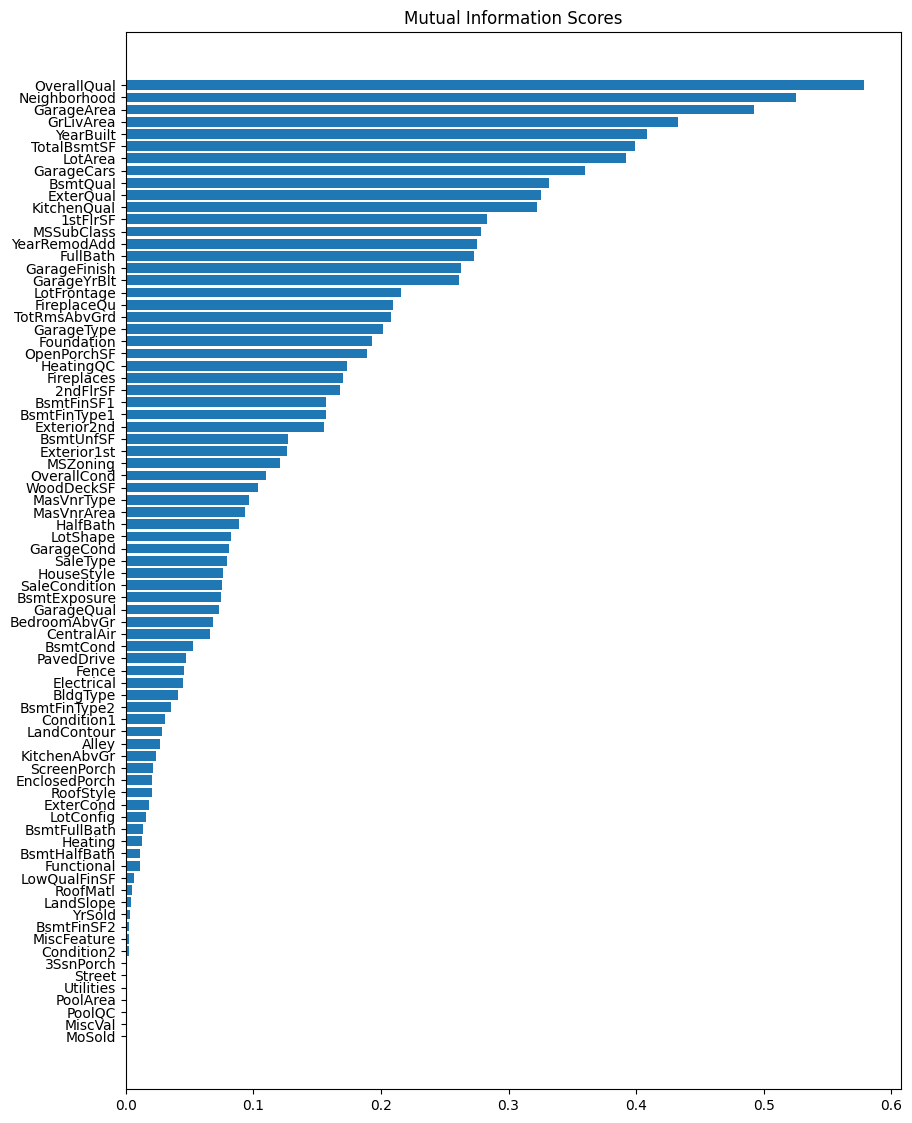

In [ ]:
plt.figure(1,dpi=100, figsize=(10, 14))
plot_mi_scores(mi_scores)

In [ ]:
row_for_consider = [row for row in range(len(mi_scores))  if mi_scores[row] > 0.2]
high_mutual_inf_lvl = mi_scores[:row_for_consider[-1]].index
high_mutual_inf_lvl

Index(['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt',
       'TotalBsmtSF', 'LotArea', 'GarageCars', 'BsmtQual', 'ExterQual',
       'KitchenQual', '1stFlrSF', 'MSSubClass', 'YearRemodAdd', 'FullBath',
       'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'FireplaceQu',
       'TotRmsAbvGrd'],
      dtype='object')

Por que tomamos scores mayores que 0.2?

Se tomo como limite 0.2 ya que a partir de ese valor, las caracteristicas restantes no parecieran ser tan relevantes a la hora de defini el precio de una propiedad.

Entonces por un lado tenemos las variables cuyo nivel de correlacion podria considerarse alto con respecto a nuestro target y por otro tenemos el nombre de variables que parecerian tener un grado alto de mutual information.

La proxima tarea sera la de crear nuevos features que nos ayuden a mejorar la prediccion en nuestro modelo de ML.

Ahora antes de empezar a crear nuevos features, sera importante la limpieza de nuestros datos (data cleaning)

### Data cleaning

Ahora, para la limpieza de nuestros datos sera crucial, para mantener un codigo limpio, juntar los datos de entrenamiento y de validacion, limpiarlos en conjunto para luego ser separados nuevamente, esto nos permitira ahorrar muchas lineas de codigo.

In [ ]:
target = df_train["SalePrice"]
df_train = df_train.drop("SalePrice", axis=1)

data_to_clean = pd.concat([df_train, df_test], axis=0, ignore_index=True)

Reemplazamos los valores nulos en variables cuantitativas por ceros y los valores nulos en variables cualitativas por el str "None". 

In [ ]:
data_to_clean.update(data_to_clean[quantitative].fillna(0))
data_to_clean.update(data_to_clean[qualitative].fillna("None"))

# check for nulls
missing_values = calculate_missing_values(data_to_clean)
missing_values

,Total,Percent


Ahora debemos tratar las variables cualitativas, vamos a optar por hacer uso del aprouch Ordinal Encoder.

In [ ]:
data_to_clean = ordinal_encoder(data_to_clean, qualitative)

Ahora veremos las distribuciones, comenzaremos por la distribucion de nuestro target, aplicaremos la transformacion de log para aproximiar la distribucion a una normal.

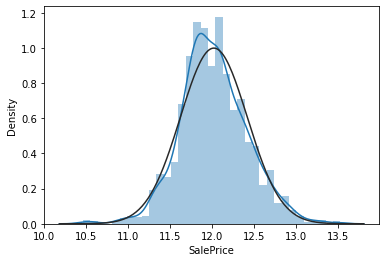

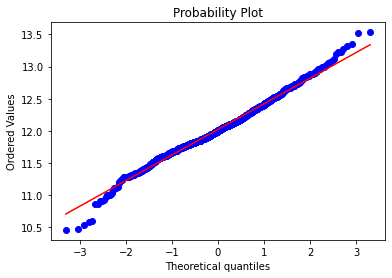

In [ ]:
# aplicamos la transformacion logaritmica
target = np.log(target)
sns.distplot(target, fit=norm);
fig = plt.figure()
res = stats.probplot(target, plot=plt)

In [ ]:
skew_features = data_to_clean[quantitative].apply(lambda x: skew(x)).sort_values(ascending=False)


high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

# aplicamos la transformacion a todos los features que presenten skewness
for i in skew_index:
    data_to_clean[i] = boxcox1p(data_to_clean[i], boxcox_normmax(data_to_clean[i] + 1))

### Feature Engineering

In [ ]:
data_to_clean = data_to_clean.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

# creamos nuevos features deacuerdo a las correlaciones antes vistas
data_to_clean['YrBltAndRemod']=data_to_clean['YearBuilt']+data_to_clean['YearRemodAdd']
data_to_clean['TotalSF']=data_to_clean['TotalBsmtSF'] + data_to_clean['1stFlrSF'] + data_to_clean['2ndFlrSF']

data_to_clean['Total_sqr_footage'] = (data_to_clean['BsmtFinSF1'] + data_to_clean['BsmtFinSF2'] +
                                 data_to_clean['1stFlrSF'] + data_to_clean['2ndFlrSF'])

data_to_clean['Total_Bathrooms'] = (data_to_clean['FullBath'] + (0.5 * data_to_clean['HalfBath']) +
                               data_to_clean['BsmtFullBath'] + (0.5 * data_to_clean['BsmtHalfBath']))

data_to_clean['Total_porch_sf'] = (data_to_clean['OpenPorchSF'] + data_to_clean['3SsnPorch'] +
                              data_to_clean['EnclosedPorch'] + data_to_clean['ScreenPorch'] +
                              data_to_clean['WoodDeckSF'])

data_to_clean['haspool'] = data_to_clean['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data_to_clean['has2ndfloor'] = data_to_clean['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data_to_clean['hasgarage'] = data_to_clean['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data_to_clean['hasbsmt'] = data_to_clean['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data_to_clean['hasfireplace'] = data_to_clean['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
X_train = data_to_clean[data_to_clean["Id"] <= 1460]
X_val = data_to_clean[data_to_clean["Id"] > 1460]

In [ ]:
X_val["Id"]

1460    1461
1461    1462
1462    1463
1463    1464
1464    1465
        ... 
2914    2915
2915    2916
2916    2917
2917    2918
2918    2919
Name: Id, Length: 1459, dtype: int64

In [ ]:
X_train["SalePrice"] = target

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,...,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,SalePrice
0,1,6.502440,4.0,65.0,13.424520,1.0,3.0,3.0,4.0,0.0,...,1321.691450,1142.714976,3.527460,12.009558,0,1,1,1,0,12.247694
1,2,4.250991,4.0,80.0,13.694527,1.0,3.0,3.0,2.0,0.0,...,412.853054,152.356425,2.355405,56.339208,0,0,1,1,1,12.109011


In [ ]:
new_feature = list(['hasfireplace', 'hasbsmt', 'hasgarage', 'has2ndfloor',  'haspool', 'Total_porch_sf', 'Total_Bathrooms', 'Total_sqr_footage', 'TotalSF',  'YrBltAndRemod'])

In [ ]:
candidate_feature = np.append(high_corr_lvl.tolist(), high_mutual_inf_lvl.tolist())

candidate_feature = list(dict.fromkeys(candidate_feature))

final_feature = candidate_feature + new_feature

In [ ]:
final_feature

['Alley',
 'Foundation',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'Neighborhood',
 'LotArea',
 'BsmtQual',
 'ExterQual',
 'KitchenQual',
 'MSSubClass',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'FireplaceQu',
 'hasfireplace',
 'hasbsmt',
 'hasgarage',
 'has2ndfloor',
 'haspool',
 'Total_porch_sf',
 'Total_Bathrooms',
 'Total_sqr_footage',
 'TotalSF',
 'YrBltAndRemod']